# An example of a Flexible Mixed-Unit Real Estate Development 

From Chapters 16 to 23 of {cite}`farevuu2018`, the authors describe and iterate 
through realistic situations where a real estate development would exercise 
options in response to market uncertainty.

This notebook condenses those chapters to showcase how *Rangekeeper* facilitates
the modelling and evaluation of realistic scenario options.

## Setup
Import the required modules

In [1]:
import json
import os

import locale
import urllib.parse
import json
import pandas as pd
import networkx as nx
from IPython.display import IFrame
import plotly.subplots
import plotly.offline as py

import rangekeeper as rk

In [2]:
locale.setlocale(locale.LC_ALL, '')
units = rk.measure.Index.registry
currency = rk.measure.register_currency(registry=units)

## 

In [3]:
params = dict(
    land_area = 106000,
    total_units = 850,
    acq_price = 200000000 * currency.units,
    far = 2.0,
    start_date= pd.Timestamp('2001-01-01'),
    num_periods = 10,
    period_type = rk.periodicity.Type.YEAR,
    acquisition_cost = -200000000 * currency.units,
    growth_rate = 0.02,
    unit_sales_proj_form=rk.distribution.PERT(
        peak=0.1333,
        weighting=12
        )
    )

In [4]:
class Model:
    def __init__(self) -> None:
        self.spaces = {}
    def set_params(self, params: dict) -> None:
        self.params = params
    def set_market(self, market: rk.dynamics.market.Market) -> None:
        self.market = market
    def init_spans(self) -> None:
        self.calc_span = rk.span.Span.from_num_periods(
            name='Span to Calculate Reversion',
            date=self.params['start_date'],
            period_type=self.params['period_type'],
            num_periods=self.params['num_periods'] + 1)
        self.acq_span = rk.span.Span.from_num_periods(
            name='Acquisition Span',
            date=rk.periodicity.offset_date(
                self.params['start_date'],
                num_periods=-1,
                period_type=self.params['period_type']),
            period_type=self.params['period_type'],
            num_periods=1)
        self.span = self.calc_span.shift(
            name='Span',
            num_periods=-1,
            period_type=self.params['period_type'],
            bound='end')
        self.reversion_span = self.span.shift(
            name='Reversion Span',
            num_periods=self.params['num_periods'] - 1,
            period_type=self.params['period_type'],
            bound='start')

In [5]:
@rk.update_class(Model)
class Model:
    def init_sales(self) -> None:
        sales_proj = rk.projection.Distribution(
                form=params['unit_sales_proj_form'],
                sequence=rk.periodicity.period_index(
                    include_start=self.calc_span.start_date,
                    period_type=params['period_type'],
                    bound=self.calc_span.end_date
                    )
                ) 
        self.total_unit_sales = rk.flux.Flow.from_projection(
            name='Total Unit Sales',
            value=params['total_units'],
            proj=sales_proj
            )
    def init_space(
            self,
            params: dict) -> None:
        self.spaces[params['name']] = dict(
            unit_sales = rk.flux.Flow(
                name='{0} Unit Sales'.format(params['name']),
                movements=self.total_unit_sales.movements * params['prop']
                )
            )

In [6]:
model = Model()
model.set_params(params=params)
model.init_spans()
model.init_sales()

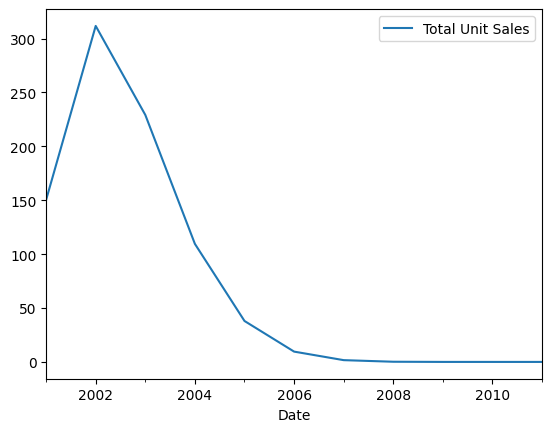

In [7]:
model.total_unit_sales.plot()

In [8]:
typeA_params = dict(
    name = 'Type A',
    prop = .5
    )
model.init_space(params=typeA_params)

In [9]:
model.spaces

{'Type A': {'unit_sales': <rangekeeper.flux.Flow at 0x2b5277160>}}

In [10]:
property = rk.graph.Assembly(
    name='Property',
    type='property'
    )
typeA = rk.graph.Assembly(
    name='Type A',
    type='A'
    )
typeB = rk.graph.Assembly(
    name='Type B',
    type='B'    
    )
property.add_relationship(relationship=(property, typeA, 'contains'))
property.add_relationship(relationship=(property, typeB, 'contains'))

In [12]:
property.plot()

Property.html
